<h3> 0. Installing Dependencies </h3>

We can install all the dependencies using the requirements.txt file

In [267]:
!pip install -r requirements.txt

<h3>1. Importing Dependencies </h3>

The cell below is for importing dependencies so run the cell regardless of the condition like Training the model from scratch or loading the h5 files and inference testing only 

In [184]:
import tensorflow as tf
from keras.layers import *
import math
import zipfile
import numpy as np
import random
import tensorflow.keras.backend as K
import os
from tqdm import tqdm
import PIL
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings('ignore')
name_of_model=['UNET','Ghosted_UNET'] 

In [2]:
SEED = 42
np.random.seed = SEED

UNZIP_PATH = 'data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


<h4>Unzipping file and sorting in Directory </h4>
<p> It is better if you run the cell below only once because it essentially unzips file and puts on the same folder again and again replacing the previous one there will be no loss of anything just redundent work </p>

In [35]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH+'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH+'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [3]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# define placeholders (also used to replace NaN in images to resize by 0)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

In [5]:
# Resize images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(
        img, (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    
    X_train[n] = img # fill empty X_train with values from img 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(
            resize(
                mask_, 
                (IMG_HEIGHT, IMG_WIDTH), 
                mode = 'constant', 
                preserve_range = True
            ), 
            axis = -1
        )
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 670/670 [03:39<00:00,  3.05it/s]


In [10]:
# test images
X_test = np.zeros(
    (
        len(test_ids), 
        IMG_HEIGHT, 
        IMG_WIDTH, 
        IMG_CHANNELS
    ), 
    dtype = np.uint8
)

sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(
        img, 
        (IMG_HEIGHT, IMG_WIDTH), 
        mode = 'constant', 
        preserve_range = True
    )
    X_test[n] = img

100%|██████████| 65/65 [00:00<00:00, 68.85it/s]


In [203]:
def save_load_history(history,name,flag):
    name=name+'_History'
    try: 
        os.mkdir(name)
    except:
        pass
    
    if flag==1:
        np.save(name+'/'+name+'.npy',history)
    else:
        try:
            history=np.load(name+'/'+name+'.npy',allow_pickle='TRUE').item()
        except:
            history={'loss':[]}
        return history

def combine_histories(initial_history,final_history):
    for i in final_history.keys():
        if i in initial_history.keys():
            initial_history[i]+=final_history[i]
        else: 
            initial_history[i]=final_history[i]
    
    return initial_history

def train_from_scratch(option,name,model):
    if option==True:
        try:
            shutil.rmtree(name+"_History")
            os.remove(name+".h5")
        except:
            pass

        final_model=model
    else:
        try:
            final_model=tf.keras.models.load_model(name+'.h5')
        except:
            final_model=model
    
    return final_model

    

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def sensitivity(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def plot_metrics_for_training(history):
    
    plt.figure(figsize=(30, 15))
    plt.subplot(411)
    plt.plot(history['dice_coef'], label='dice_coef')
    plt.plot(history['val_dice_coef'], label = 'val_dice_coef')
    plt.xticks(np.arange(len(history['dice_coef'])), np.arange(1, len(history['dice_coef'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('dice score')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(412)
    plt.plot(history['sensitivity'], label='sensitivity')
    plt.plot(history['specificity'], label = 'specificity')
    plt.xticks(np.arange(len(history['sensitivity'])), np.arange(1, len(history['sensitivity'])+1))
    #plt.xticks(np.arange(len(history['val_accuracy'])), np.arange(1, len(history['val_accuracy'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity and Specificity')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(413)
    plt.plot(history['val_sensitivity'], label='val_sensitivity')
    plt.plot(history['val_specificity'], label = 'val_specificity')
    plt.xticks(np.arange(len(history['val_sensitivity'])), np.arange(1, len(history['val_sensitivity'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('val_Sensitivity and val_Specificity')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

def ConvBnLayer(x, oup, kernel_size, stride, padding='same'):
    y = Conv2D(filters=oup, kernel_size=kernel_size, strides=stride, padding=padding)(x)
    #y = BatchNormalization(epsilon=1e-5, momentum=0.1)(y)
    return y

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def SELayer(x, reduction=4):
    batch, _, __, channel = x.shape
    y = GlobalAveragePooling2D()(x)
    y = Dense(units=channel // reduction, activation='relu')(y)
    y = Dense(units=channel, activation='sigmoid')(y)
    y = Reshape([1, 1, channel])(y)
    se_tensor = Multiply()([x, y])
    return se_tensor


def DepthWiseConv(x, kernel_size=3, stride=1, depth_multiplier=1, padding='same', relu=False):
    y = DepthwiseConv2D(kernel_size=kernel_size // 2, depth_multiplier=depth_multiplier,
                        strides=stride, padding=padding)(x)
    #y = BatchNormalization(epsilon=1e-5, momentum=0.1)(y)
    if relu:
        y = Activation('relu')(y)
    return y


def GhostModule(x, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
    init_channels = math.ceil(oup / ratio)
    new_channels = init_channels * (ratio - 1)

    multiplier = new_channels // init_channels

    primary_tensor = ConvBnLayer(x, init_channels, kernel_size=kernel_size, stride=stride, padding='same')
    if relu:
        primary_tensor = Activation('relu')(primary_tensor)

    cheap_tensor = DepthWiseConv(primary_tensor, kernel_size=dw_size,
                                 depth_multiplier=multiplier, padding='same', stride=1)
    if relu:
        cheap_tensor = Activation('relu')(cheap_tensor)

    out = Concatenate()([primary_tensor, cheap_tensor])
    return Lambda(lambda x: x[:, :, :, :oup])(out)

def GhostBottleneck(x, hidden_dim, oup, kernel_size, stride, use_se):
    assert stride in [1, 2]
    inp = x.shape[-1]
    if stride == 1 and inp == oup:
        shortcut = x
    else:
        shortcut = DepthWiseConv(x, kernel_size=3, stride=stride, relu=False)
        shortcut = ConvBnLayer(shortcut, oup, 1, 1, padding='same')

    x = GhostModule(x, hidden_dim, kernel_size=1, relu=True)
    if stride == 2:
        x = DepthWiseConv(x, kernel_size, stride, relu=False)
    if use_se:
        x = SELayer(x)
    x = GhostModule(x, oup, kernel_size=1, relu=False)
    return Add()([x, shortcut])


def ghosted_layer(x,filters):
    cfgs =[3, 2, 1, 1] # k, t, SE, s
    
    output_channel = filters
    #x = ConvBnLayer(x, output_channel, 3, 2, padding='same')
    output_channel = _make_divisible(filters * 1.3, 2)
    hidden_channel = _make_divisible(cfgs[1] * 50, 2)
    x = GhostBottleneck(x, hidden_channel, output_channel, cfgs[0], cfgs[3], cfgs[2])
    print(f'Input Features: {filters}, Ghosted UNET Features: {output_channel}')
    return x

In [204]:
def UNET_ghosted_UNET(ghosted_flag):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization
    if (ghosted_flag==0):
        # Contraction path
        c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
        p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

        c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
        p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

        c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
        p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

        c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
        p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

    else: 
        #c1 = tf.keras.layers.Conv2D(8, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
        c1=ghosted_layer(s,16)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1=ghosted_layer(c1,16)
        #c1=ghosted_layer(c1,16)
        p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

        c2=ghosted_layer(p1,32)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        #c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
        c2=ghosted_layer(c2,32)
        p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

        c3=ghosted_layer(p2,64)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3=ghosted_layer(c3,64)
        p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

        c4=ghosted_layer(p3,128)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4=ghosted_layer(c4,128)
        p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

        c5=ghosted_layer(p4,256)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5=ghosted_layer(c5,256)
        c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

 
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs],name=name_of_model[ghosted_flag])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,sensitivity,specificity])
    model.summary()
    return model

<h4> Number of Epcohs </h4>
Set the number of epochs here since this project is for comparative analysis both models will be trained the same number of times 

In [248]:
number_of_epochs=20

<h3> UNET Training </h3>

In [249]:
# Callbacks
u_net_model=UNET_ghosted_UNET(0)
checkpointer = tf.keras.callbacks.ModelCheckpoint(str(u_net_model.name)+'.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience =5, monitor='val_dice_coef', mode='max',restore_best_weights=True),
    checkpointer
]
initial_unet_model=u_net_model

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_673 (Lambda)            (None, 128, 128, 3)  0           ['input_42[0][0]']               
                                                                                                  
 conv2d_1274 (Conv2D)           (None, 128, 128, 16  448         ['lambda_673[0][0]']             
                                )                                                                 
                                                                                               

<h4> Train model from scartch </h4>

Check if we want to train the model from scratch (If Flase don't change, change only when you need to remove all the saved model files automatically and start from first ) or not initially defaule value set to False but can be set to true to restart all the model training from first 


In [253]:
u_net_model=train_from_scratch(False,"UNET",initial_unet_model)

In [254]:

initial_unet=save_load_history(0,'UNET',0)
results = u_net_model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.2, 
    batch_size = 32, 
    initial_epoch=len(initial_unet['loss']),
    epochs = len(initial_unet['loss'])+number_of_epochs,
    callbacks = callbacks)

results=combine_histories(initial_unet,results.history)
save_load_history(results,'UNET',1)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 0.4727 - dice_coef: 0.3712 - sensitivity: 0.1405 - specificity: 0.9931
Epoch 1: val_loss improved from inf to 0.33410, saving model to UNET.h5
17/17 [==============================] - 18s 1s/step - loss: 0.4727 - dice_coef: 0.3712 - sensitivity: 0.1405 - specificity: 0.9931 - val_loss: 0.3341 - val_dice_coef: 0.4647 - val_sensitivity: 0.3542 - val_specificity: 0.9865
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.3090 - dice_coef: 0.5560 - sensitivity: 0.5550 - specificity: 0.9657
Epoch 2: val_loss improved from 0.33410 to 0.24625, saving model to UNET.h5
17/17 [==============================] - 18s 1s/step - loss: 0.3090 - dice_coef: 0.5560 - sensitivity: 0.5550 - specificity: 0.9657 - val_loss: 0.2462 - val_dice_coef: 0.6312 - val_sensitivity: 0.7372 - val_specificity: 0.9668
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.2349 - dice_coef: 0.6874 - sensitivity: 0.7922 - s

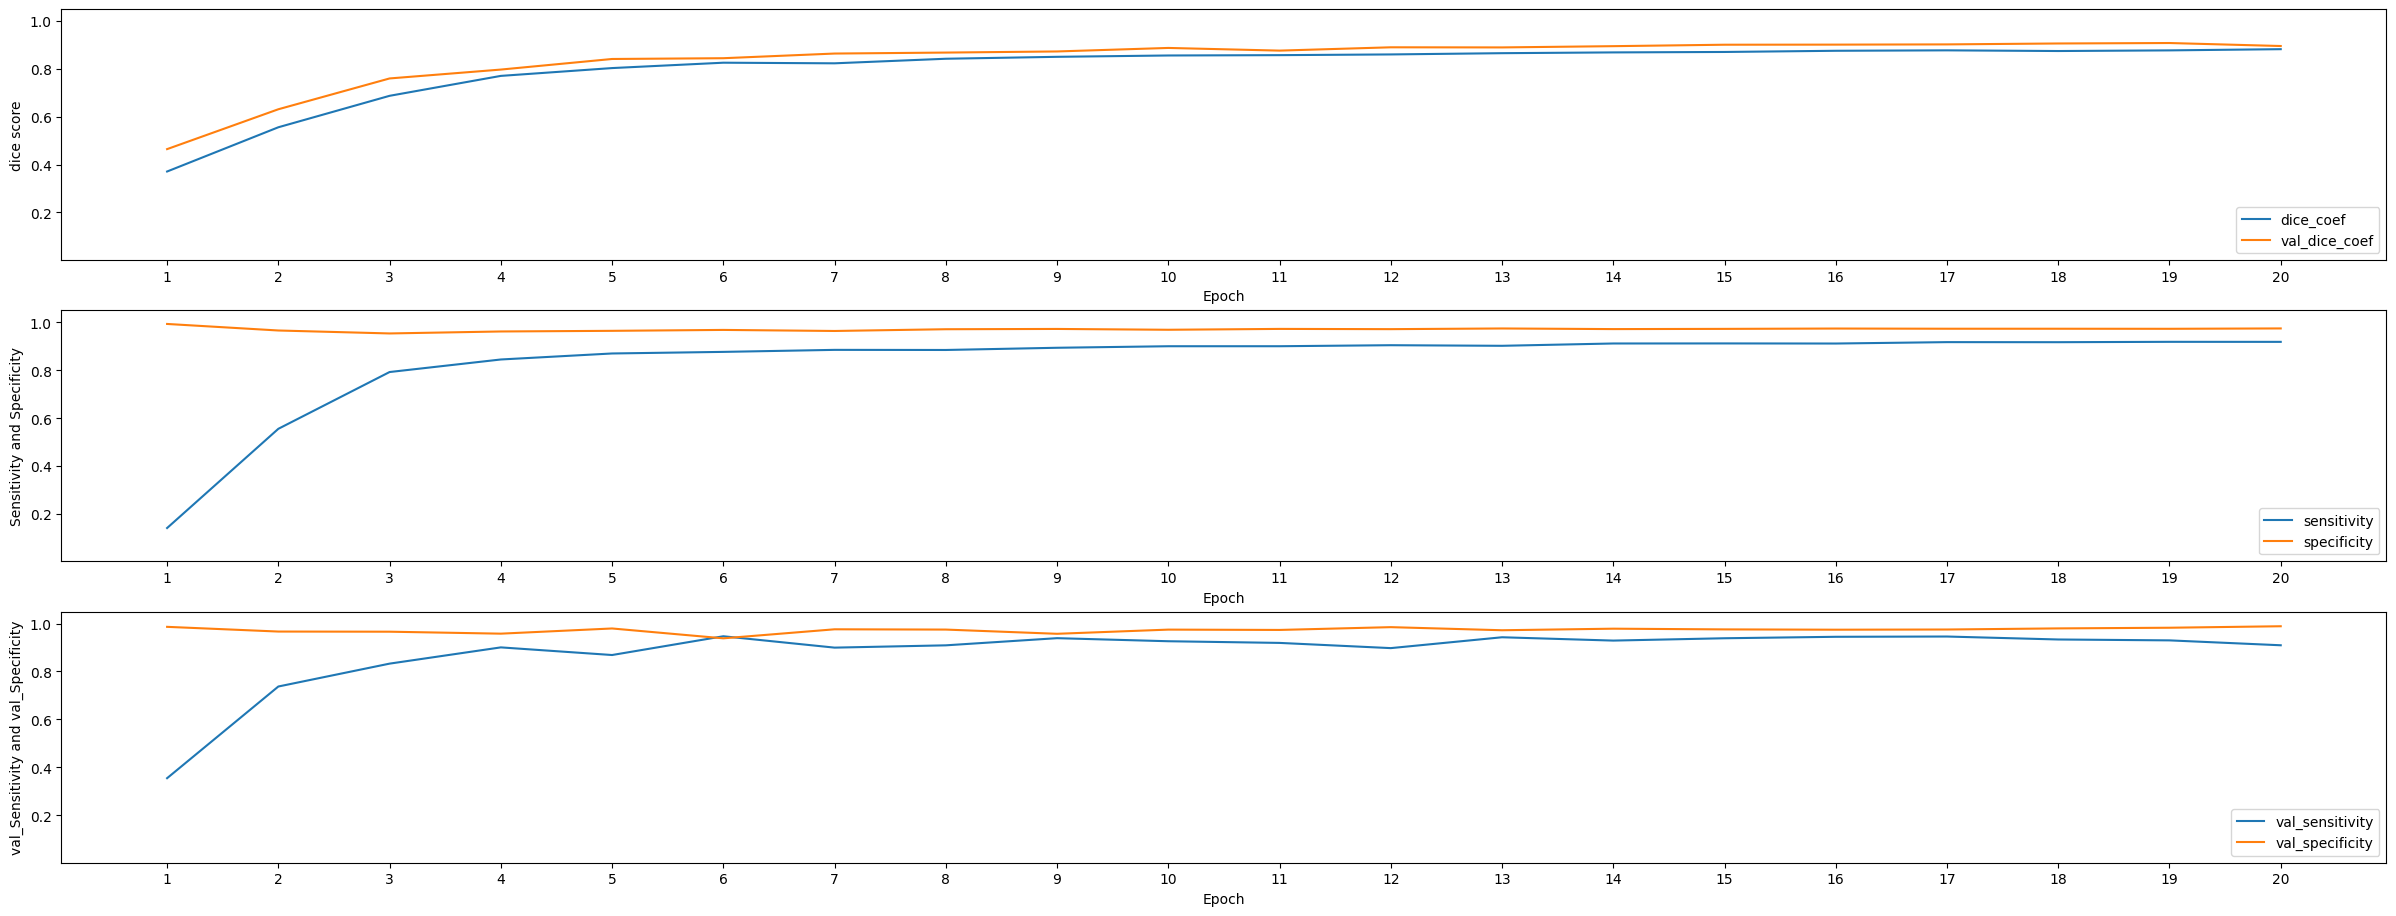

In [255]:
plot_metrics_for_training(results)

<h3> Ghosted UNET Training </h3>

In [256]:
ghosted_u_net_model=UNET_ghosted_UNET(1)
checkpointer_ghosted = tf.keras.callbacks.ModelCheckpoint(str(ghosted_u_net_model.name)+'.h5', verbose = 1, save_best_only = True)
callbacks_ghosted = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_dice_coef', mode='max',restore_best_weights=True),
    checkpointer_ghosted
]
initial_ghosted_u_net=ghosted_u_net_model

Input Features: 16, Ghosted UNET Features: 20
Input Features: 16, Ghosted UNET Features: 20
Input Features: 32, Ghosted UNET Features: 42
Input Features: 32, Ghosted UNET Features: 42
Input Features: 64, Ghosted UNET Features: 84
Input Features: 64, Ghosted UNET Features: 84
Input Features: 128, Ghosted UNET Features: 166
Input Features: 128, Ghosted UNET Features: 166
Input Features: 256, Ghosted UNET Features: 332
Input Features: 256, Ghosted UNET Features: 332
Model: "Ghosted_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_674 (La

<h4> Train model from scartch </h4>

Check if we want to train the model from scratch (If Flase don't change, change only when you need to remove all the saved model files automatically and start from first ) or not initially defaule value set to False but can be set to true to restart all the model training from first 


In [258]:

ghosted_u_net_model=train_from_scratch(False,"Ghosted_UNET",initial_ghosted_u_net)

In [259]:
initial_ghosted=save_load_history(0,'Ghosted_UNET',0)
results_ghosted=ghosted_u_net_model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.2, 
    batch_size = 32,
    initial_epoch=len(initial_ghosted['loss']),
    epochs = len(initial_ghosted['loss'])+number_of_epochs) 

results_ghosted=combine_histories(initial_ghosted,results_ghosted.history)
ghosted_u_net_model.save(str(ghosted_u_net_model.name)+'.h5')
save_load_history(results_ghosted,'Ghosted_UNET',1)

Epoch 1/20
17/17 [==============================] - 51s 2s/step - loss: 0.6317 - dice_coef: 0.2899 - sensitivity: 0.0610 - specificity: 0.9438 - val_loss: 0.5704 - val_dice_coef: 0.2641 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
17/17 [==============================] - 44s 3s/step - loss: 0.5333 - dice_coef: 0.2816 - sensitivity: 3.8934e-06 - specificity: 1.0000 - val_loss: 0.4745 - val_dice_coef: 0.3078 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
17/17 [==============================] - 45s 3s/step - loss: 0.4611 - dice_coef: 0.3495 - sensitivity: 0.0041 - specificity: 1.0000 - val_loss: 0.4184 - val_dice_coef: 0.3636 - val_sensitivity: 0.0049 - val_specificity: 1.0000
Epoch 4/20
17/17 [==============================] - 43s 3s/step - loss: 0.3931 - dice_coef: 0.4261 - sensitivity: 0.2677 - specificity: 0.9874 - val_loss: 0.3504 - val_dice_coef: 0.4881 - val_sensitivity: 0.4653 - val_specificity: 0.9871
Epoch 5/20
17/17 [==================

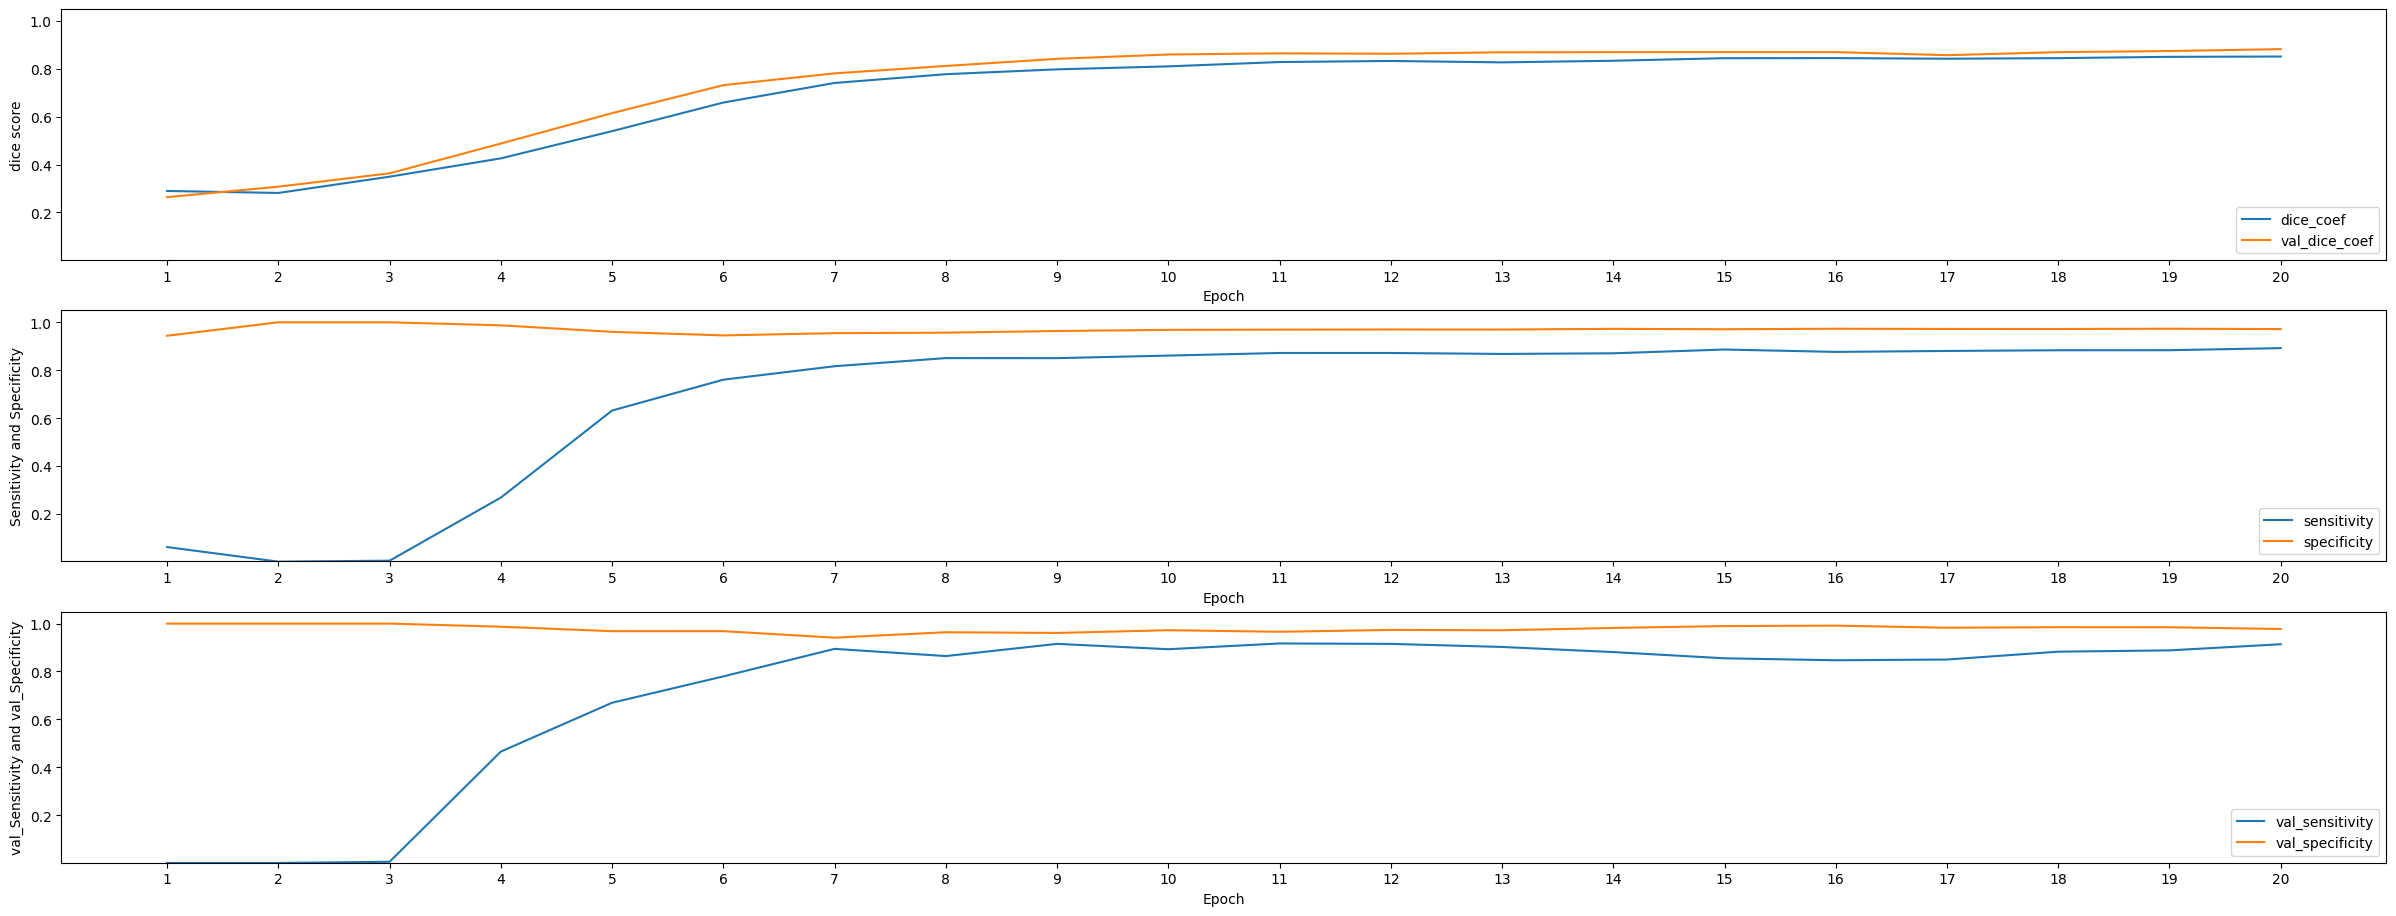

In [260]:
plot_metrics_for_training(results_ghosted)

<h3> Inference Testing </h3>

Run the topic 1. Importing Dependencies cell  and directly Run the cell below if you have model files present with you. Else Run from top

Ghosted_UNET Performance: 


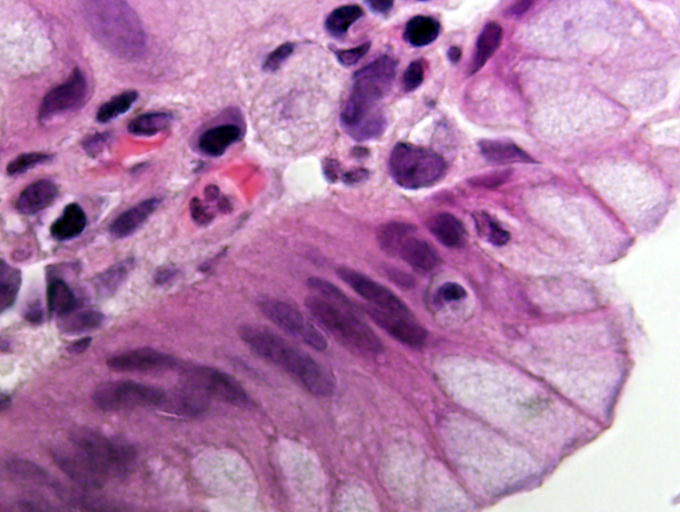

1/1 [==============================] - 1s 520ms/step


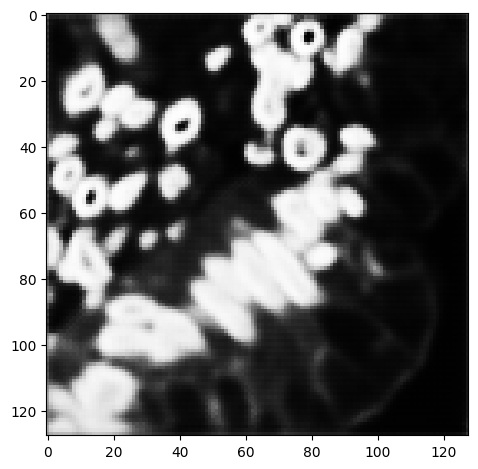

In [265]:
def load_model():
    model_flag=int(input(f'Enter 0 for {name_of_model[0]} and 1 for {name_of_model[1]}: '))
    loaded_model=tf.keras.models.load_model(str(name_of_model[model_flag])+'.h5',compile=False)
    return loaded_model

def get_inference_image(var_arg:'''str or numpy array''',flag:'''bool''')->'''Image or Numpy array or both''':
    if flag==False:
        image_org=PIL.Image.open(var_arg).convert('RGB')
        display(image_org)
        image=image_org.resize((128,128))
        #print(image.shape)
        return image_org,np.asarray(image)
    else: 
        image=(np.squeeze(var_arg)*255.0).astype(np.uint8)
        image=imshow(image)
        return image
        
def save_inference_images_and_predictions(original_image,output_image,model):
    try:
        os.mkdir(model.name+'_Inferences')
    except:
        pass

    original_image.save(model.name+'_Inferences/Inference_Original.jpg')
    plt.savefig(model.name+'_Inferences/Inference_Predicted.jpg',bbox_inches='tight')
    

loaded_model=load_model()
print(loaded_model.name+' Performance: ')
original_image,input_image=get_inference_image(input('Enter Path for the image: '),False)
output_image=get_inference_image(loaded_model.predict(input_image.reshape(1,input_image.shape[0],input_image.shape[1],input_image.shape[2])),True)
display(output_image)
save_inference_images_and_predictions(original_image,output_image,loaded_model)
